<h6> Telecom Churn Rate <h6>

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew, boxcox
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,RandomForestClassifier
import time
from sklearn.metrics import  make_scorer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from catboost import CatBoostClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
#!pip install mlxtend  

<h3> Reading all dataframes and exploring size and shape<h3>

In [3]:
ensemble_df = pd.read_csv("TelcomCustomer-churn.csv")
part1_df =  pd.read_csv("TelcomCustomer-Churn_1.csv")
part2_df =  pd.read_csv("TelcomCustomer-Churn_2.csv")

In [4]:
ensemble_df.head()
#print(ensemble_df.shape)
plot_df = ensemble_df.copy()

In [8]:
print("shape",ensemble_df.shape)
print("data frame description",ensemble_df.describe().transpose)

shape (7043, 21)
data frame description <bound method DataFrame.transpose of        SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000>


In [9]:
print("shape",part1_df.shape)
print("data frame description",part1_df.describe().transpose)

shape (7043, 10)
data frame description <bound method DataFrame.transpose of        SeniorCitizen       tenure
count    7043.000000  7043.000000
mean        0.162147    32.371149
std         0.368612    24.559481
min         0.000000     0.000000
25%         0.000000     9.000000
50%         0.000000    29.000000
75%         0.000000    55.000000
max         1.000000    72.000000>


In [10]:
print("shape",part2_df.shape)
print("data frame description",part2_df.describe().transpose)

shape (7043, 12)
data frame description <bound method DataFrame.transpose of        MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000>


- Not merging this dataframe, since dataframe 1 i.e (ensemble_df) is already a merged dataframe of other dataframes
- Using dataframe 1 which has all the columns from dataframe 2 and dataframe 3

In [11]:
ensemble_df.isnull().sum(axis =0)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [12]:
 pd.isnull(ensemble_df["TotalCharges"]).value_counts()

False    7043
Name: TotalCharges, dtype: int64

In [13]:
ensemble_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [14]:
ensemble_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


<h3> Data cleansing <h3>
    - Convert Datatype of column
 

In [15]:
for col in ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','PaperlessBilling','PaymentMethod','Churn','StreamingMovies']:
    ensemble_df[col] = ensemble_df[col].astype('category')
cat_type = CategoricalDtype(categories=["Month-to-month", "One year", "Two year"], ordered=True)
ensemble_df['Contract'] = ensemble_df['Contract'] .astype(cat_type)
ensemble_df['TotalCharges'] = pd.to_numeric(ensemble_df['TotalCharges'],errors='coerce')
ensemble_df['TotalCharges']= ensemble_df['TotalCharges'].astype('float')

In [16]:
ensemble_df.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

<h3> Total charges has null values in 11 records- dropping null values - <h3>

In [17]:
ensemble_df.isnull().sum(axis =0)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [18]:
#ensemble_df.TotalCharges.fillna(value=ensemble_df.MonthlyCharges*0, inplace=True)
ensemble_df.dropna(axis = 0, inplace =True)

In [19]:
ensemble_df.isnull().sum(axis =0)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

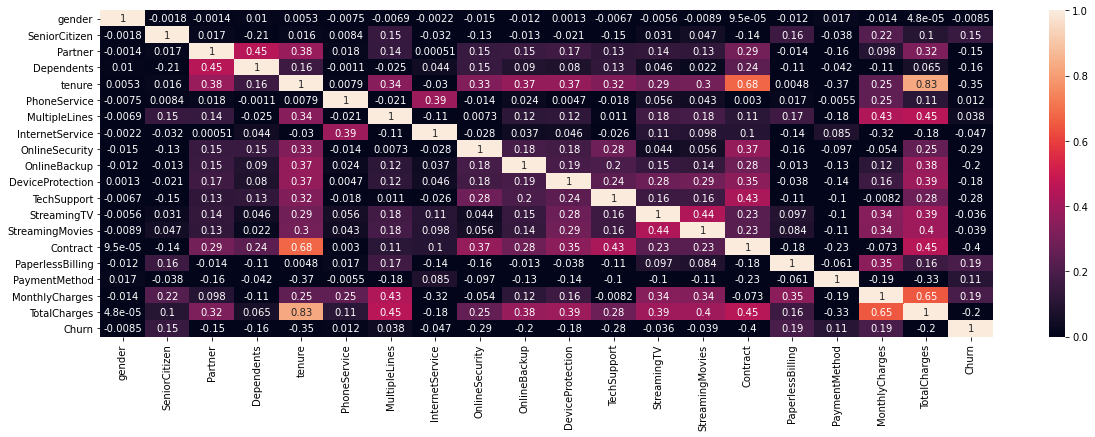

In [198]:
plt.figure(figsize=(20,6))
k = sns.heatmap(data = ensemble_df.corr(),vmin=0, vmax=1, annot=True)


- Tenure and Totalcharges haves high correlation. 
- Totalcharges can be a product of tenure * charges for services they have availed


C:\Users\ss1\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


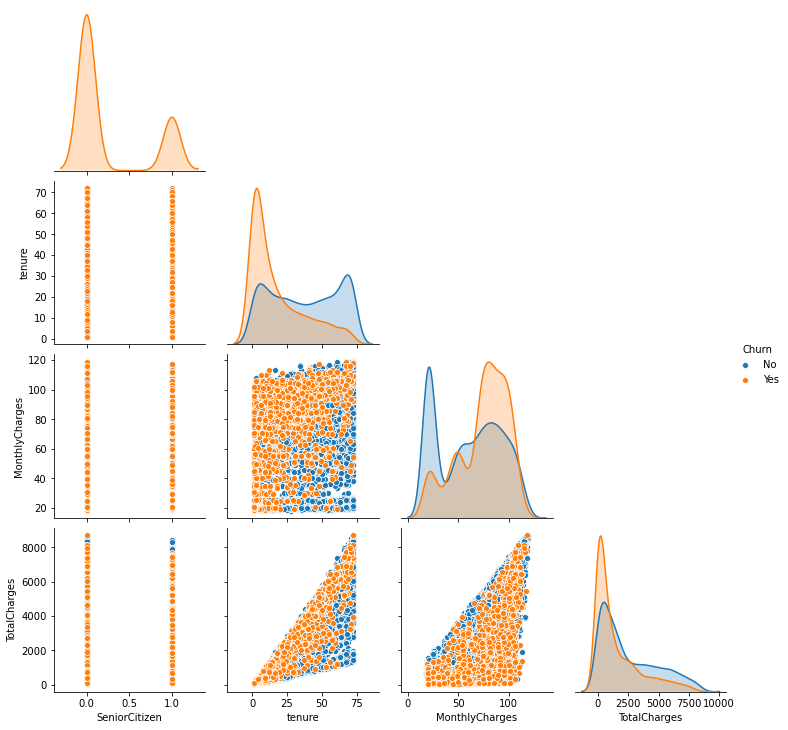

In [21]:
sns.pairplot(ensemble_df,hue = 'Churn',corner=True)

- Pairplot clearly shows that data is skewed
- Totalcharges and tenure are positively skewed
- Monthly charges for churn record is positively skewed
- Monthy charges for not churn records are negatively skewed

<h3> label encoder - converts categorical values to numericals <h3> 

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ensemble_df.columns:
    
    if str(ensemble_df[col].dtype) == 'category':
            ensemble_df[col] =le.fit_transform(ensemble_df[col])
            print(ensemble_df[col].value_counts())
       
        

1    3549
0    3483
Name: gender, dtype: int64
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
0    3639
1    3393
Name: Partner, dtype: int64
0    4933
1    2099
Name: Dependents, dtype: int64
1    6352
0     680
Name: PhoneService, dtype: int64
0    3385
2    2967
1     680
Name: MultipleLines, dtype: int64
1    3096
0    2416
2    1520
Name: InternetService, dtype: int64
0    3497
2    2015
1    1520
Name: OnlineSecurity, dtype: int64
0    3087
2    2425
1    1520
Name: OnlineBackup, dtype: int64
0    3094
2    2418
1    1520
Name: DeviceProtection, dtype: int64
0    3472
2    2040
1    1520
Name: TechSupport, dtype: int64
0    2809
2    2703
1    1520
Name: StreamingTV, dtype: int64
0    2781
2    2731
1    1520
Name: StreamingMovies, dtype: int64
0    3875
2    1685
1    1472
Name: Contract, dtype: int64
1    4168
0    2864
Name: PaperlessBilling, dtype: int64
2    2365
3    1604
0    1542
1    1521
Name: PaymentMethod, dtype: int64
0    5163
1    1869
Name: Churn, dtype: in

<h3> Feature importance using DecisionTreeRegressor<h3>

In [23]:
X_train, X_test, y_train, y_test = train_test_split(ensemble_df.drop(['Churn','customerID'],axis = 1), ensemble_df.iloc[:,-1], test_size=0.30, random_state=1)
regressor = DecisionTreeRegressor(random_state=0, max_depth=6)

regressor.fit(X_train , y_train)
feature_importances = regressor.feature_importances_


feature_names = ensemble_df.drop(['Churn','customerID'],axis = 1).columns
#print(feature_names)

k = 8

#print(feature_importances)
top_k_idx = (feature_importances.argsort()[-k:][::-1])

print(feature_names[top_k_idx], feature_importances)
feature_imp_dict = dict(zip(feature_names,feature_importances))
feature_imp_dict = pd.DataFrame.from_dict(feature_imp_dict,orient ='index')
feature_imp_dict.sort_values(by=0, ascending=False)

Index(['Contract', 'MonthlyCharges', 'OnlineSecurity', 'TotalCharges',
       'tenure', 'MultipleLines', 'StreamingMovies', 'PaperlessBilling'],
      dtype='object') [4.37317563e-03 6.43586036e-03 6.32061083e-03 1.04904210e-03
 9.29892615e-02 0.00000000e+00 1.29326051e-02 0.00000000e+00
 1.15620192e-01 4.95735376e-03 1.03649686e-04 7.50447127e-03
 0.00000000e+00 1.16887384e-02 4.76236211e-01 8.60094905e-03
 3.77680530e-03 1.48473187e-01 9.89378873e-02]


,0
Contract,0.476236
MonthlyCharges,0.148473
OnlineSecurity,0.115620
TotalCharges,0.098938
tenure,0.092989
MultipleLines,0.012933
StreamingMovies,0.011689
PaperlessBilling,0.008601
TechSupport,0.007504
SeniorCitizen,0.006436


- importance of features are listed above in descending order
- streaming Tv, Internetservice and phone service has no importance at all

<h3> dropping Customer Id<h3>
- customer Id has no importance in model creation

In [24]:
df = ensemble_df.copy()
df.drop('customerID',axis =1,inplace =True)


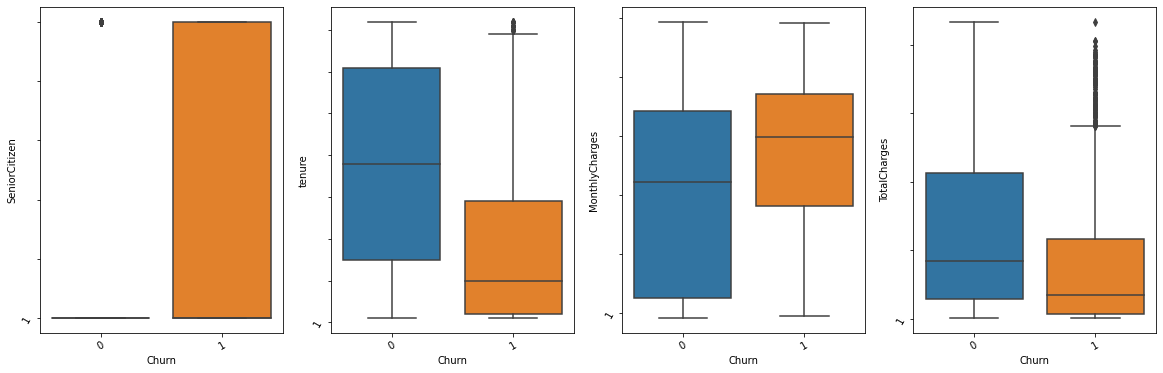

In [25]:


num_col = df.select_dtypes(include=['int64','float64'])
#num_col['Churn'] = df['Churn']
plt.figure(figsize=(20,6))
count =0
for i in num_col.columns:
    count = count+1
    #print(count,i)
    plt.subplot(1,4,count)
   # plt.title(i)
    g = sns.boxplot(x='Churn',y=i,data = ensemble_df)
    g.set_xticklabels(g.get_xticklabels(),rotation=30)
    g.set_yticklabels(g.get_xticklabels(),rotation=60)
    #plt.ylim(0,5000)

- there is a huge difference in median of tenure for churners and non churners
- it's surprising to know that churners have higher Median of Monthly charges
- Non churners has higher median of totalcharges

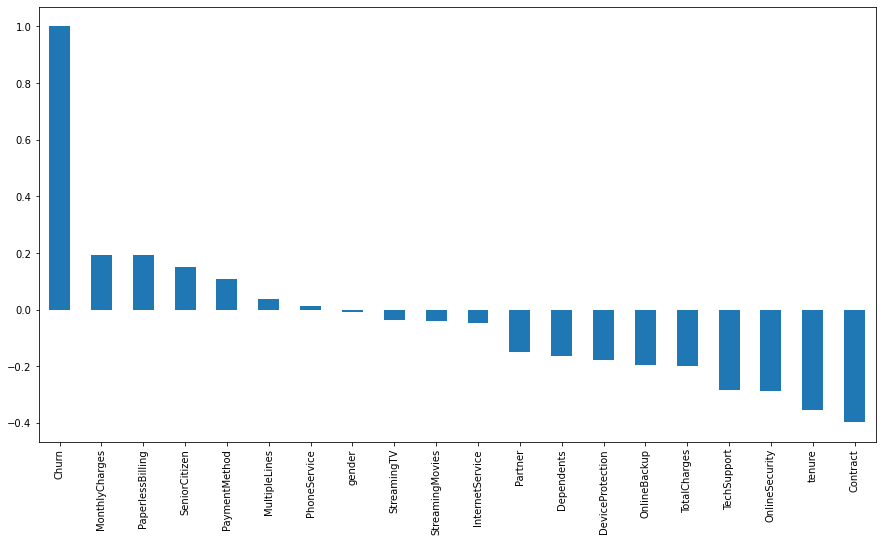

In [26]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

- correlation of all features with respect to churn

In [192]:
tab = pd.crosstab(df['Partner'],df ['Churn'],margins_name="Total",margins =True)
tab

Churn,0,1,Total
Partner,,,
0,2439,1200,3639
1,2724,669,3393
Total,5163,1869,7032


In [194]:
print("percentage of churners with partner {}".format(round(tab.loc[1,1]/tab.loc[1,'Total'],2)) )
print("percentage of churners with out partner {}".format(round(tab.loc[0,1]/tab.loc[0,'Total'],2)) )

percentage of churners with partner 0.2
percentage of churners with out partner 0.33


<h6> Hypothesis to compare proportion of customers who churn with partners and withourt partners <h6>
     
    
    
    Null Hypothesis
    
    proportion of customers who churn with partners and without partners are  equal
    
    
    
    Alternate Hypothesis
    
    proportion of ccustomers who churn with partners and without partners not equal
    
    
  Test for significance
    If P value is less than significant level , reject the null hypothesis
    if P values is greater than significant level, failed to reject null hypothesis
    
    why 2 proportion Test?
    we have to compare 2 categorical sample - 2 proportion test

In [216]:
from statsmodels.stats.proportion import proportions_ztest
partner_churn = tab.loc[1,1]
no_partner_churn = tab.loc[0,1]
n_partner = tab.loc[1,'Total']
n_no_partner =tab.loc[0,'Total']
stat,pval = proportions_ztest([partner_churn,no_partner_churn],[n_partner,n_no_partner ])
#print (stat,pval)
if pval<0.05:
    print("reject null hypothesis :proportion of customers who churn with partners and without partners are  equal ")
else:
    print("failed to reject null hypothesis : proportion of customers who churn with partners and without partners  are  equal")

reject null hypothesis :proportion of customers who churn with partners and without partners are  equal 


In [27]:
df_no_churn = plot_df[plot_df.Churn.eq('No')]
df_churn =plot_df[plot_df.Churn.eq('Yes')]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


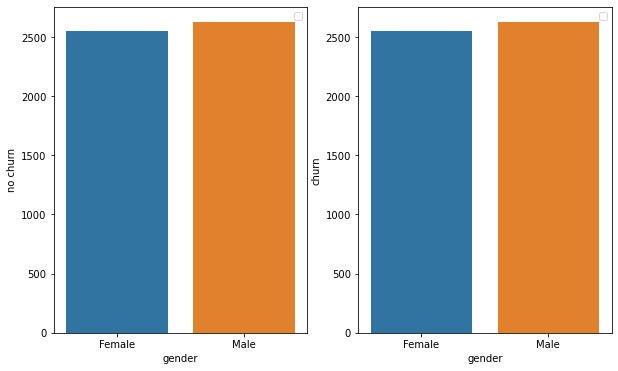

In [29]:

fig_dim = (10,6)
fig, ax = plt.subplots(figsize = (fig_dim))


plt.subplot(1,2,1)
sns.countplot(df_no_churn.gender)

plt.ylabel('no churn')
plt.legend()

plt.subplot(1,2,2)
sns.countplot(df_no_churn.gender)

plt.ylabel('churn')
plt.legend()
plt.show()

- Gender doesn't seem to play any role in churn rate

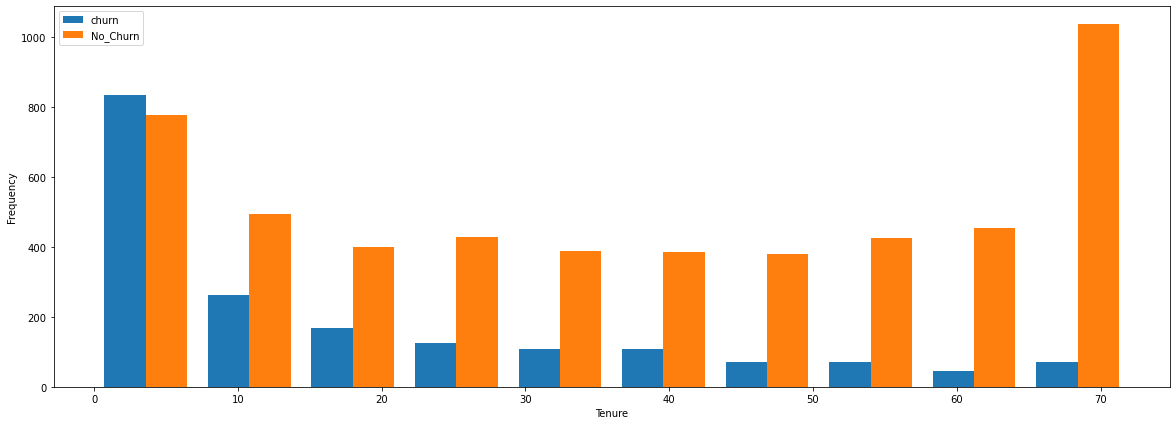

In [31]:
plt.figure(figsize=(20,7))

plt.hist([df_churn.tenure,df_no_churn.tenure],label =['churn','No_Churn'])
plt.ylabel('Frequency')
plt.xlabel('Tenure')
plt.legend()

- People tend to churn maximum at start of the tenure or after 70 months of tenure

In [33]:
df1 = df.groupby(['PaymentMethod']).mean()[['MonthlyCharges']].reset_index()
df1.head()

,PaymentMethod,MonthlyCharges
0,0,67.205577
1,1,66.519264
2,2,76.255814
3,3,43.958354


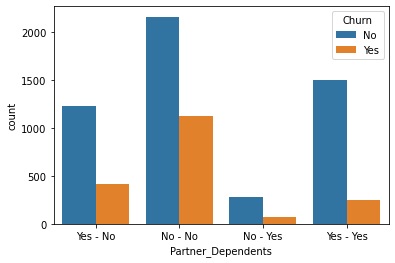

In [35]:
plot_df['Partner_Dependents'] = plot_df['Partner'] + ' - ' + plot_df['Dependents']
#sns.catplot(data= plot_df,x ='Partner_Dependents',hue ='Churn')
sns.countplot(x="Partner_Dependents", hue="Churn", data=plot_df)


- Churn rate is higher when customer doesn't have partner and dependant

[Text(0, 0, 'Electronic check'),
 Text(0, 0, 'Mailed check'),
 Text(0, 0, 'Bank transfer (automatic)'),
 Text(0, 0, 'Credit card (automatic)')]

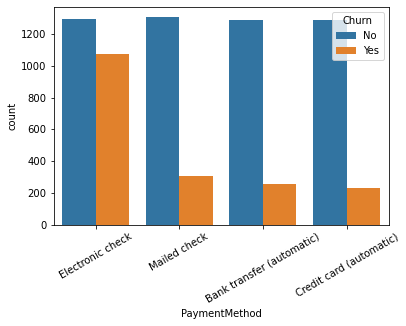

In [36]:
g =sns.countplot(x="PaymentMethod", hue="Churn", data=plot_df)
g.set_xticklabels(g.get_xticklabels(),rotation=30)

- customers who use electronic check as payment mode tend to churn alot

[Text(0, 0, 'Month-to-month'), Text(0, 0, 'One year'), Text(0, 0, 'Two year')]

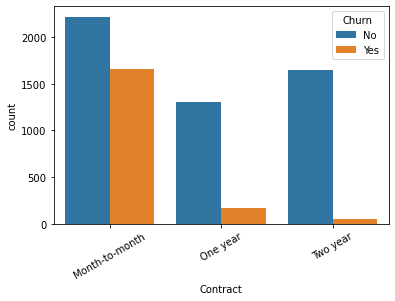

In [37]:
g =sns.countplot(x="Contract", hue="Churn", data=plot_df)
g.set_xticklabels(g.get_xticklabels(),rotation=30)

- customers who use MOnth-to-Month contract tend to churn at higher rate

In [38]:
plot_df['services']= plot_df['MultipleLines']+'_'+plot_df['OnlineSecurity']+'_'+plot_df['OnlineBackup']+'_'+plot_df['DeviceProtection']+'_'+plot_df['TechSupport']+'_'+plot_df['StreamingTV']+'_'+plot_df['StreamingMovies']
plot_df['services'] = plot_df['services'].apply(lambda x : x.strip().replace('internet service'," ").strip().replace('phone service'," ").strip())
plot_df['services']= plot_df['services'].apply(lambda x : x.strip())

In [40]:
#flag = 0 = no all
#flag = 1 = yes all
#flag =2 = atleast one serive
def any_service_used(service):
    yes_cnt = 0
    service = service.split('_') 
    for i in service:
        if i.strip() == 'Yes':
            yes_cnt = yes_cnt +1
        else:
            pass
    return yes_cnt

In [41]:
plot_df['services']= plot_df['services'].apply(any_service_used)

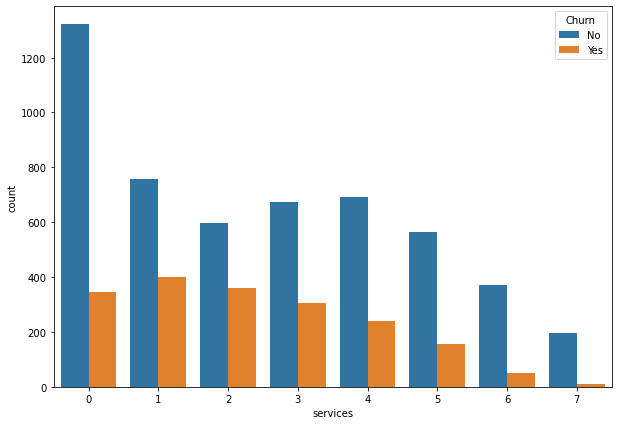

In [43]:
plt.figure(figsize=(10,7))
g =sns.countplot(x="services", hue="Churn", data=plot_df)

<h3> No of services used by customer <h3>
    
- customers who didn't avail any service have higher churn rate
    
- customers who availed all the service has less churn rate

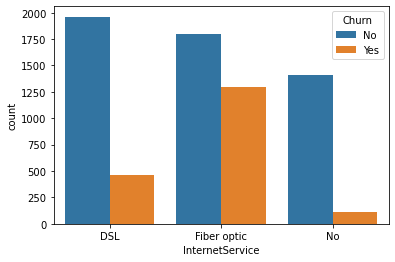

In [44]:
 sns.countplot(x="InternetService", hue="Churn", data=plot_df)

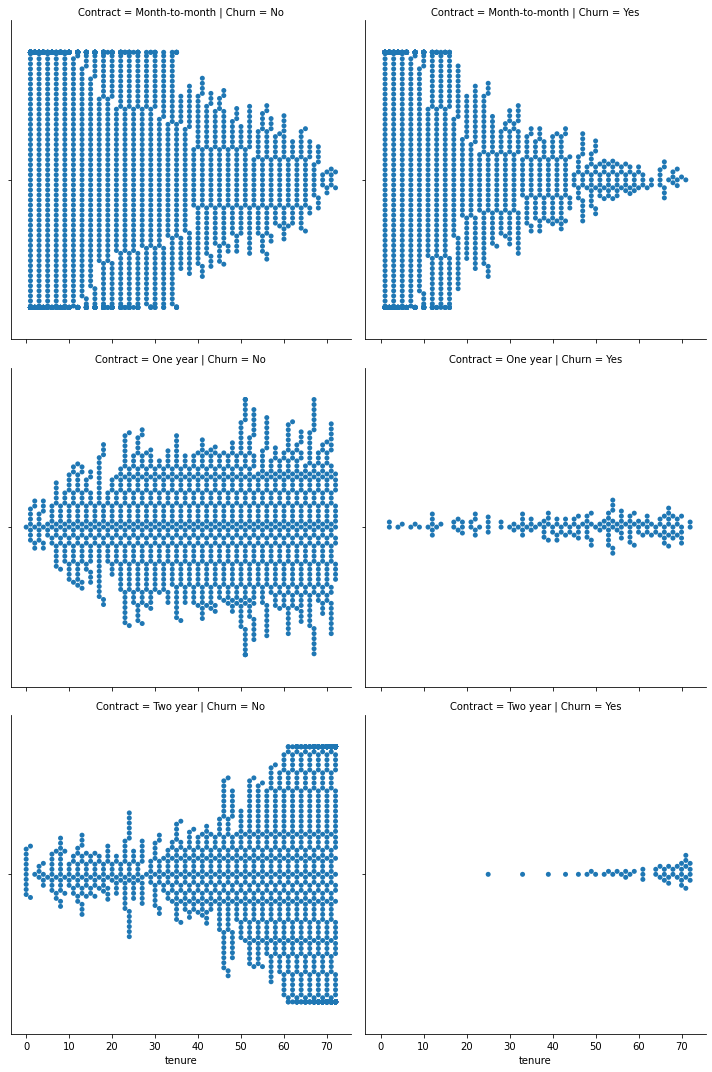

In [45]:
sns.catplot(data = plot_df, x = 'tenure',row = 'Contract', col = 'Churn',kind='swarm')

- customers who uses month-to-moth contract has higher churn rate than one year and two year
- customers with highest tenure months churn at higher rate only if they opted for a contract either one year or two year
- customers who optes for monthly plan churn at the start of the tenure than later

In [46]:
contract_churn = plot_df.groupby(['Contract','Churn']).size().unstack()
contract_churn

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


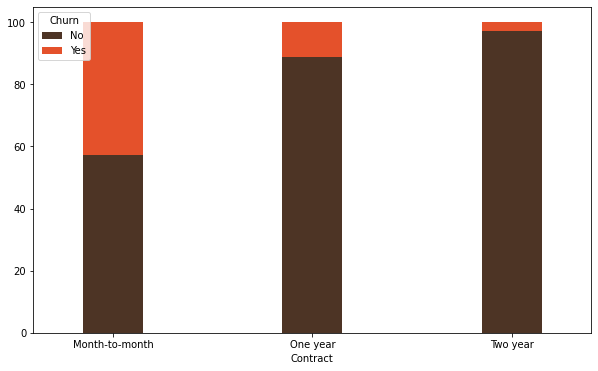

In [51]:
colors = ['#4D3425','#E4512B']
ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)

<h3> skewness<h3>

In [53]:
ensemble_df.agg(['skew']).columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

C:\Users\ss1\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ss1\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


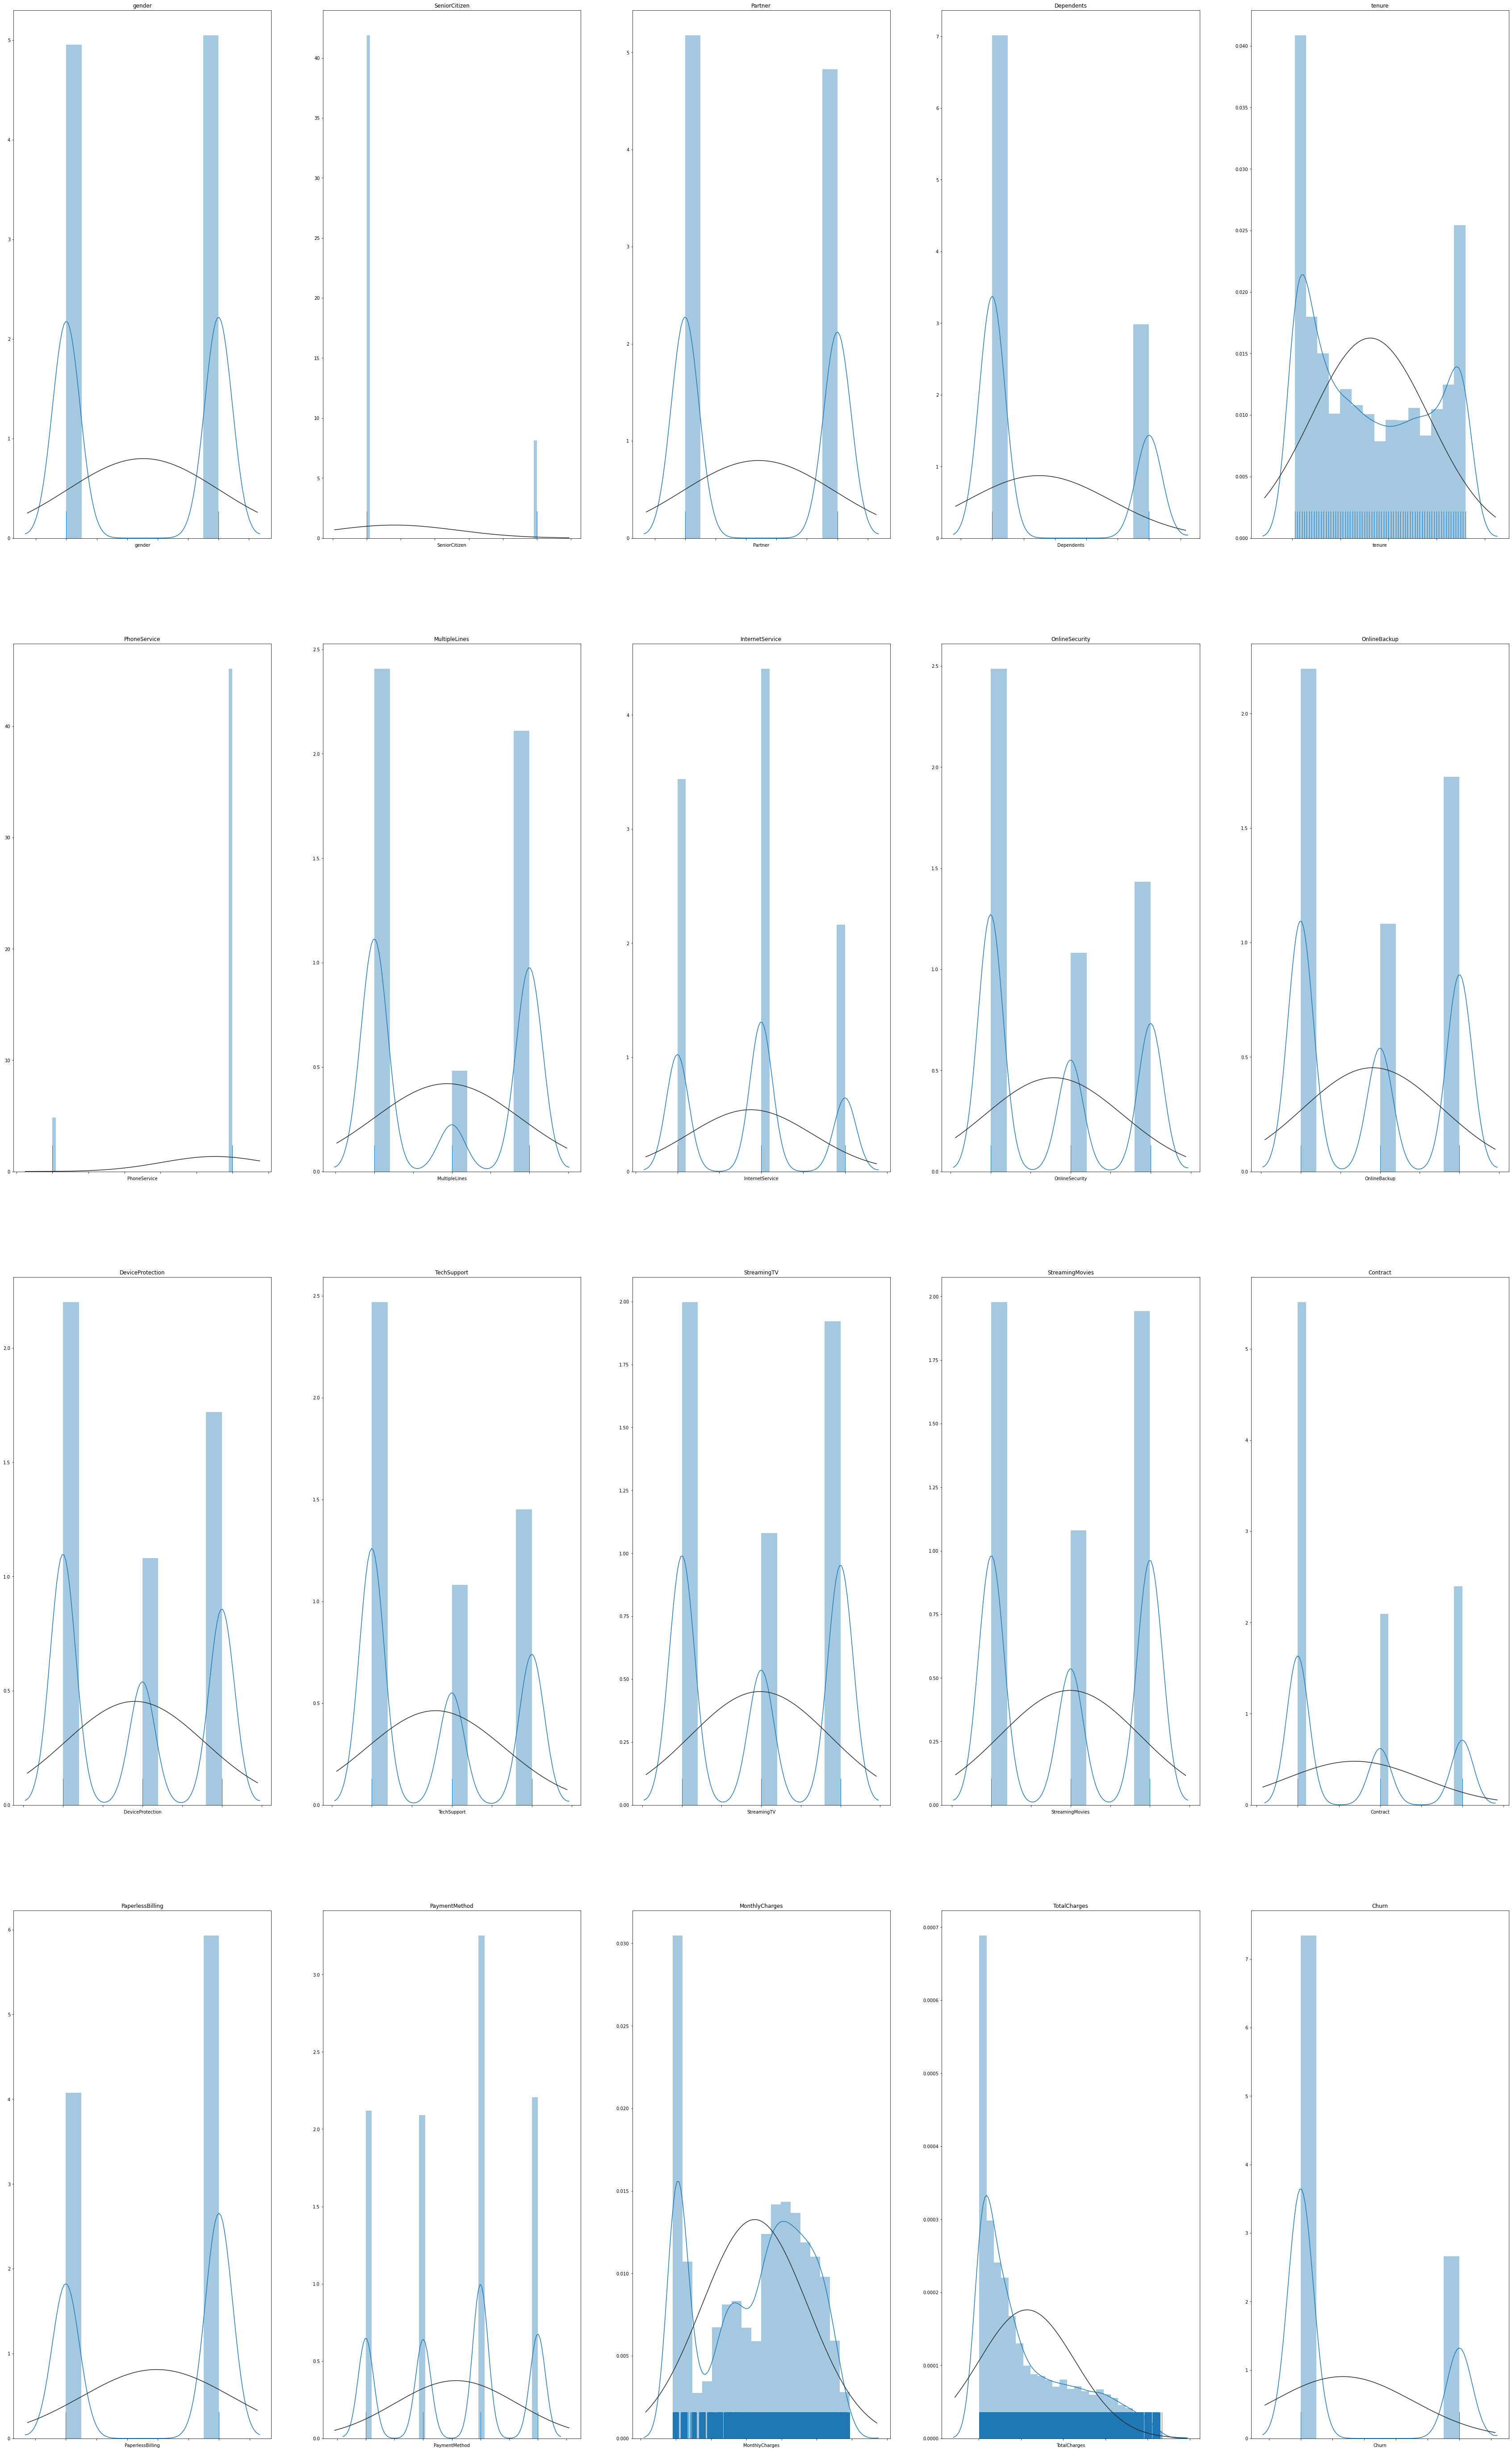

In [54]:

plt.figure(figsize=(60,100))
count =0

for i in  ensemble_df.agg(['skew']).columns:
   
    count = count+1
    plt.subplot(4,5,count)
    plt.title(i)
    #g = sns.countplot(i,data =ensemble_df, hue = 'Churn')
    g = sns.distplot(ensemble_df[i], fit = norm, rug=True)
    g.set_xticklabels(g.get_xticklabels(),rotation=30)

- Monthly charges,Total charges and tenure are positively skewed

In [56]:
ensemble_df1 = ensemble_df.copy()


<h3> handling skewness<h3>

- we can't transform categorical features
- taking log of Totalcharges and Monthly charges to handle skewness

In [58]:
ensemble_df1['TotalCharges'] = ensemble_df1['TotalCharges'] .replace(0.0, 0.1)
ensemble_df1['MonthlyCharges']=np.log(ensemble_df1['MonthlyCharges'])
ensemble_df1['TotalCharges']=np.log(ensemble_df1['TotalCharges']) #ensemble_df1[col]=np.log(ensemble_df1[col])


In [59]:
ensemble_df1.skew()


gender             -0.018776
SeniorCitizen       1.831103
Partner             0.070024
Dependents          0.880908
tenure              0.237731
PhoneService       -2.729727
MultipleLines       0.118623
InternetService     0.205704
OnlineSecurity      0.418619
OnlineBackup        0.184089
DeviceProtection    0.188013
TechSupport         0.403966
StreamingTV         0.029366
StreamingMovies     0.013851
Contract            0.635149
PaperlessBilling   -0.377503
PaymentMethod      -0.169388
MonthlyCharges     -0.730938
TotalCharges       -0.753574
Churn               1.060622
dtype: float64

<h6> Feature engineering <h6>

- combining all services into one column 
    
    
    {'MultipleLines', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies}
    
- not using this in modelling since it reduces accuracy

In [60]:
#feature engineering
ensemble_df2 = ensemble_df.copy()
ensemble_df2['services']= plot_df['MultipleLines']+'_'+plot_df['OnlineSecurity']+'_'+plot_df['OnlineBackup']+'_'+plot_df['DeviceProtection']+'_'+plot_df['TechSupport']+'_'+plot_df['StreamingTV']+'_'+plot_df['StreamingMovies']
ensemble_df2['services'] = ensemble_df2['services'].apply(lambda x : x.strip().replace('internet service'," ").strip().replace('phone service'," ").strip())
ensemble_df2['services']= ensemble_df2['services'].apply(lambda x : x.strip())

ensemble_df2['services']= ensemble_df2['services'].apply(any_service_used)
ensemble_df2['TotalCharges'] = ensemble_df2['TotalCharges'] .replace(0.0, 0.1)
ensemble_df2['MonthlyCharges']=np.log(ensemble_df2['MonthlyCharges'])
ensemble_df2['TotalCharges']=np.log(ensemble_df2['TotalCharges']) #ensemble_df1[col]=np.log(ensemble_df1[col])
ensemble_df2.drop(['MultipleLines', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'], axis = 1, inplace =True)
#plot_df['services']= plot_df['MultipleLines']+'_'+plot_df['OnlineSecurity']+'_'+plot_df['OnlineBackup']+'_'+plot_df['DeviceProtection']+'_'+plot_df['TechSupport']+'_'+plot_df['StreamingTV']+'_'+plot_df['StreamingMovies']
#plot_df['services'] = plot_df['services'].apply(lambda x : x.strip().replace('internet service'," ").strip().replace('phone service'," ").strip())
#plot_df['services']= plot_df['services'].apply(lambda x : x.strip())



<h6> standard scaling <h6>
    
- It doesn't impact accuracy at higher rate 
    
    
- decision trees do not require normalization of their input
    
    
- Most of ensemble agorithms are built on top of decision tree in this notebook
- Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.
    

In [61]:
from sklearn.preprocessing import StandardScaler
#X_b = model_bank_data.drop(['LoanOnCard','ID','ZipCode'],axis=1)
#Y_b = model_bank_data['LoanOnCard']
scaler = StandardScaler()

#= scaler.fit(X)
#sm = SMOTE(random_state = 2)
#X_train_res, y_train_res = sm.fit_sample(X_b, Y_b)
#ensemble3=scaler.fit_transform(ensemble_df)

In [62]:
ensemble_df3 = ensemble_df.copy()
cleanup_nums = {"OnlineSecurity":     {2: 1, 1: 0},
                "OnlineBackup": {2: 1, 1: 0},
                "DeviceProtection":{2: 1, 1: 0},
                "TechSupport":{2: 1, 1: 0},
                "StreamingTV":{2: 1, 1: 0},
                "StreamingMovies":{2: 1, 1: 0}
                                  }

ensemble_df3 = ensemble_df3.replace(cleanup_nums)
ensemble_df3['TotalCharges'] = ensemble_df3['TotalCharges'] .replace(0.0, 0.1)
ensemble_df3['MonthlyCharges']=np.log(ensemble_df3['MonthlyCharges'])
ensemble_df3['TotalCharges']=np.log(ensemble_df3['TotalCharges'])
ensemble_df4 = ensemble_df3.copy()
ensemble_df4 = ensemble_df4.drop(['tenure'],axis = 1)

<h3> dropping tenure since it's in high correlation with Total charges <h3>

- if two varibales are highly correlated they provide redundant information to models
- it may help to decrease dimensionality

In [63]:
model_df =ensemble_df4



# seggregating Train Test


In [64]:
xscaled =scaler.fit_transform( model_df.drop(['Churn','customerID'],axis = 1))

#X_train, X_test, y_train, y_test = train_test_split(xscaled, ensemble_df.iloc[:,-1], test_size=0.30, random_state=1)
#X_train, X_test, y_train, y_test = scaler.fit_transform(X_train, X_test, y_train, y_test)
#X_train = scaler.fit_transform(X_train)
#y_train = scaler.fit_transform(y_train)


<h3>Using Smote to handle Imbalanced class</h3>

In [65]:

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
XScaled , y_scaled = sm.fit_sample(xscaled , model_df.iloc[:,-1])
df_smote_over = pd.concat([pd.DataFrame(XScaled), pd.DataFrame( y_scaled, columns=['Churn'])], axis=1)
print("value count of class after smote\n\n",df_smote_over['Churn'].value_counts())

value count of class after smote

 1    5163
0    5163
Name: Churn, dtype: int64


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Churn - Value count with SMOTE vs Churn - Value count with out SMOTE 


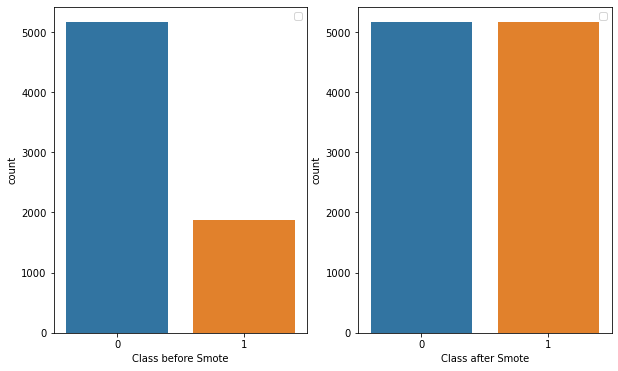

In [66]:
fig_dim = (10,6)
fig, ax = plt.subplots(figsize = (fig_dim))

print("Churn - Value count with SMOTE vs Churn - Value count with out SMOTE ")
plt.subplot(1,2,1)
sns.countplot(data =ensemble_df, x ='Churn')
plt.xlabel("Class before Smote")
plt.legend()

plt.subplot(1,2,2)
sns.countplot(data =df_smote_over, x ='Churn')
plt.xlabel('Class after Smote')

plt.legend()
plt.show()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(['Churn','customerID'],axis = 1), model_df.iloc[:,-1], test_size=0.3, random_state=1)

<h3>covariate shift - To understand if predictor variables have different characteristic in Train Vs test</h3>

In [68]:
X_train['Is_Train'] = 1
X_test['Is_Train'] = 0
#combining test and train data
df_combine = pd.concat([X_train, X_test], axis=0, ignore_index=True)
#dropping ‘target’ column as it is not present in the test
#df_combine = df_combine.drop(‘target’, axis =1)
y = df_combine['Is_Train'].values #labels
x = df_combine.drop('Is_Train', axis=1).values #covariates or our independent variables
tst, trn = X_train.values, X_test.values
m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape) #creating an empty prediction array
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 
    m.fit(X_train, y_train)
    probs = m.predict_proba(X_test)[:, 1] #calculating the probability
    predictions[test_idx] = probs
print('ROC-AUC for train and test distributions:', roc_auc_score(y, predictions))
if (roc_auc_score(y, predictions) < 0.8):
    print("No strog evidence to imply covariate shift")
else:
    print("Covariate shift exists")



ROC-AUC for train and test distributions: 0.5045653425667908
No strog evidence to imply covariate shift


In [69]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(['Churn','customerID'],axis = 1), model_df.iloc[:,-1], test_size=0.3, random_state=1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(XScaled , y_scaled, test_size=0.3, random_state=1)

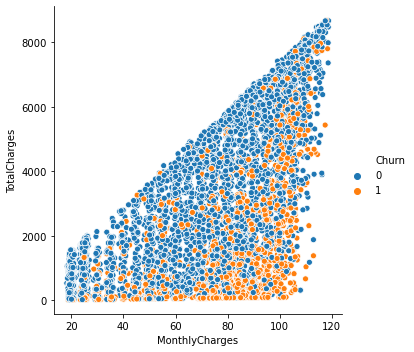

In [71]:
sns.relplot(
    data=ensemble_df,
    x="MonthlyCharges", y="TotalCharges", hue="Churn"
)

In [72]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("Training score of xgboost",metrics.accuracy_score(y_train, model.predict(X_train)))
print("Test score of xgboost",metrics.accuracy_score(y_test, preds))


C:\Users\ss1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training score of xgboost 0.9446596568898727
Test score of xgboost 0.8457069076823758


# Ensemble Techniques used in notebook



- <h3> Bagging </h3> 

    -  base_estimator = DecisionTreeClassifier.
    
    -  Random forest
    
- <h3>  Boosting </h3>

    - XGboost,Ada bosting,Extreme Gradient Boosting Machine (XGBM),cat boost 
    
- <h3>  stacking </h3>

     - Base models are XGboost,Ada bosting,Extreme Gradient Boosting Machine (XGBM),cat boost 
     
     - stacking model used as a meta model is(level 1) logistic regression
       
     - used voting classifier for base models
    
     

<h3> Bagging classifier  </h3>

In [73]:
scoring = { 'Recall': make_scorer(recall_score, average='binary')}


In [74]:


# define dataset
#X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20)
# define models and parameters
Bg_model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
bg_grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
bg_grid_search = GridSearchCV(estimator=Bg_model , param_grid=bg_grid, n_jobs=-1, cv=cv, scoring=scoring, refit='Recall',error_score=0)
Bg_model_grid_result = bg_grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (Bg_model_grid_result.best_score_, Bg_model_grid_result.best_params_))
means = Bg_model_grid_result.cv_results_['mean_test_Recall']
stds = Bg_model_grid_result.cv_results_['std_test_Recall']
params = Bg_model_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.851148 using {'n_estimators': 1000}
0.802599 (0.022076) with: {'n_estimators': 10}
0.845744 (0.018021) with: {'n_estimators': 100}
0.851148 (0.018045) with: {'n_estimators': 1000}


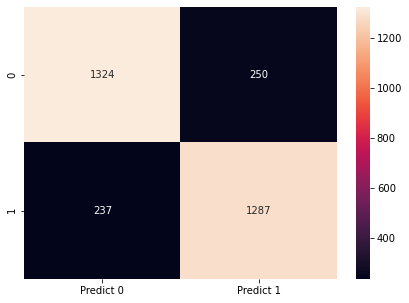

In [75]:
mat_train = confusion_matrix(y_test, Bg_model_grid_result.predict(X_test),labels=[0,1])

df_cm = pd.DataFrame(mat_train, index = [i for i in [0, 1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='.4g')

In [92]:
print("\n\n\n Classification report for \n\n\n",classification_report(y_test, Bg_model_grid_result.predict(X_test),labels=[0,1]))




 Classification report for 


               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1574
           1       0.84      0.84      0.84      1524

    accuracy                           0.84      3098
   macro avg       0.84      0.84      0.84      3098
weighted avg       0.84      0.84      0.84      3098



<h3> boosting - XGboost <h3>

In [77]:
xgb_model = XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              #'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


xgb_clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
                  scoring=scoring, refit='Recall',
                   verbose=2)
xgbresult = xgb_clf.fit(X_train, y_train)
print("Best: %f using %s" % (xgbresult.best_score_, xgbresult.best_params_))
means = xgbresult.cv_results_['mean_test_Recall']
stds = xgbresult.cv_results_['std_test_Recall']
params = xgbresult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
[19:34:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.838967 using {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}
0.838967 (0.021093) with: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}


C:\Users\ss1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


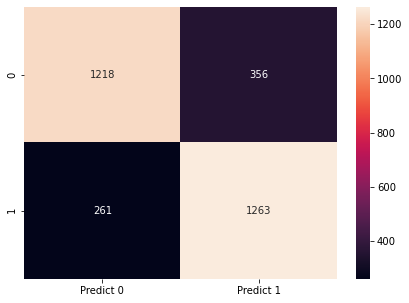

In [78]:
mat_train = confusion_matrix(y_test, xgbresult.predict(X_test),labels=[0,1])

df_cm = pd.DataFrame(mat_train, index = [i for i in [0, 1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='.4g')

In [93]:
print("\n\n\n Classification report for \n\n\n",classification_report(y_test,xgbresult.predict(X_test),labels=[0,1]))




 Classification report for 


               precision    recall  f1-score   support

           0       0.82      0.77      0.80      1574
           1       0.78      0.83      0.80      1524

    accuracy                           0.80      3098
   macro avg       0.80      0.80      0.80      3098
weighted avg       0.80      0.80      0.80      3098



In [80]:
#xgbresult.get_params_

<h3> boosting -Ada bosting <h3>

In [81]:
#['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'
ab_model =  AdaBoostClassifier()
parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              #'max_depth': [6],
              #'min_child_weight': [11],
              #'silent': [1],
              #'subsample': [0.8],
              #'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              #'seed': [1337]
}


ab_clf = GridSearchCV(ab_model, parameters, n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
                  scoring=scoring, refit='Recall',
                   verbose=2)
ab_result = ab_clf.fit(X_train, y_train)
print("Best: %f using %s" % (ab_result.best_score_, ab_result.best_params_))
means = ab_result.cv_results_['mean_test_Recall']
stds = ab_result.cv_results_['std_test_Recall']
params = ab_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Best: 0.916735 using {'learning_rate': 0.05, 'n_estimators': 5}
0.916735 (0.015243) with: {'learning_rate': 0.05, 'n_estimators': 5}


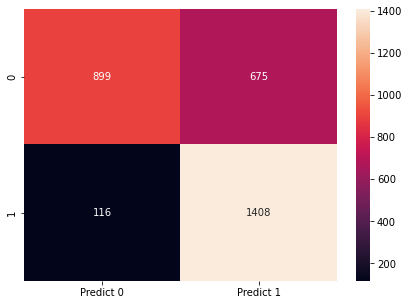

In [82]:
mat_train = confusion_matrix(y_test, ab_result.predict(X_test),labels=[0,1])

df_cm = pd.DataFrame(mat_train, index = [i for i in [0, 1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='.4g')

In [213]:
print("\n\n\n Classification report for adaboost \n\n\n",classification_report(y_test,ab_result.predict(X_test),labels=[0,1]))




 Classification report for adaboost 


               precision    recall  f1-score   support

           0       0.89      0.57      0.69      1574
           1       0.68      0.92      0.78      1524

    accuracy                           0.74      3098
   macro avg       0.78      0.75      0.74      3098
weighted avg       0.78      0.74      0.74      3098



<h3> boosting -Extreme Gradient Boosting Machine (XGBM) </h3>

In [84]:
Extreme_gb_model = lgb.LGBMClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              #'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


Extreme_gb_clf = GridSearchCV(Extreme_gb_model, parameters, n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
                  scoring=scoring, refit='Recall',
                   verbose=2)
Extreme_gb_result = Extreme_gb_clf.fit(X_train, y_train)
print("Best: %f using %s" % (Extreme_gb_result.best_score_,Extreme_gb_result.best_params_))

means = Extreme_gb_result .cv_results_['mean_test_Recall']
stds = Extreme_gb_result .cv_results_['std_test_Recall']
params = Extreme_gb_result .cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Best: 0.837222 using {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}
0.837222 (0.016875) with: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}


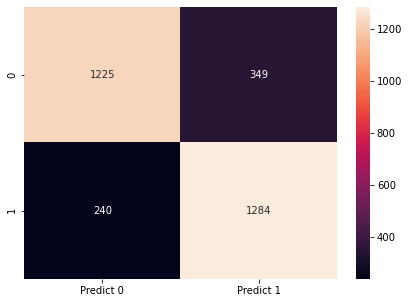

In [85]:
mat_train = confusion_matrix(y_test, Extreme_gb_result.predict(X_test),labels=[0,1])

df_cm = pd.DataFrame(mat_train, index = [i for i in [0, 1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='.4g')

In [86]:
print("\n\n\n Classification report for \n\n\n",classification_report(y_test,Extreme_gb_result.predict(X_test),labels=[0,1]))

'              precision    recall  f1-score   support\n\n           0       0.84      0.78      0.81      1574\n           1       0.79      0.84      0.81      1524\n\n    accuracy                           0.81      3098\n   macro avg       0.81      0.81      0.81      3098\nweighted avg       0.81      0.81      0.81      3098\n'

In [87]:
print("test score",Extreme_gb_result.score(X_test, y_test))

test score 0.84251968503937


<h3> boosting - cat boost <h3>


In [88]:
cat_model = CatBoostClassifier()

cat_clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)
parameters = {
    #'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              #'max_depth': [6],
              #'min_child_weight': [11],
              #'silent': [1],
              #'subsample': [0.8],
              #'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              #'seed': [1337]
             }

cat_clf = GridSearchCV(cat_model, parameters, n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
                  scoring=scoring, refit='Recall',
                   verbose=2)

cat_result = cat_clf.fit(X_train, y_train)
print("Best: %f using %s" % (cat_clf.best_score_, cat_clf.best_params_))
means = cat_result.cv_results_['mean_test_Recall']
stds = cat_result.cv_results_['std_test_Recall']
params = cat_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6766444	total: 156ms	remaining: 623ms
1:	learn: 0.6631435	total: 160ms	remaining: 240ms
2:	learn: 0.6496545	total: 164ms	remaining: 110ms
3:	learn: 0.6372952	total: 168ms	remaining: 42.1ms
4:	learn: 0.6243284	total: 173ms	remaining: 0us
Best: 0.877986 using {'learning_rate': 0.05, 'n_estimators': 5}
0.877986 (0.020125) with: {'learning_rate': 0.05, 'n_estimators': 5}


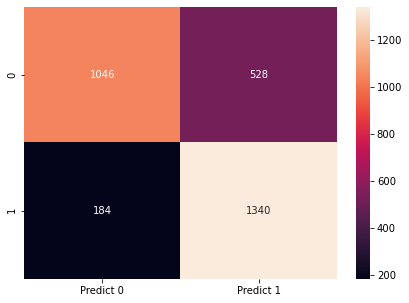

In [89]:
mat_train = confusion_matrix(y_test, cat_result.predict(X_test),labels=[0,1])

df_cm = pd.DataFrame(mat_train, index = [i for i in [0, 1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='.4g')

In [90]:
print("\n\n\n Classification report for \n\n\n",classification_report(y_test,cat_result.predict(X_test),labels=[0,1]))

'              precision    recall  f1-score   support\n\n           0       0.85      0.66      0.75      1574\n           1       0.72      0.88      0.79      1524\n\n    accuracy                           0.77      3098\n   macro avg       0.78      0.77      0.77      3098\nweighted avg       0.78      0.77      0.77      3098\n'

<h3> random forest </h3>

In [94]:

RF_model = RandomForestClassifier()


parameters = {
    'bootstrap': [True,False],
 'ccp_alpha':[ 0.0,1.0],
 
 'criterion': ['gini','entropy'],
 
 
 'min_samples_leaf': [1,2,3,4,5,6,7,8],
 'min_samples_split': [6,7,8,9,10,11,12],
 
 'n_estimators': [3]
 
             }

RF_clf = GridSearchCV(RF_model, parameters, n_jobs=-1, 
                   cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1), 
                  scoring=scoring, refit='Recall',
                   verbose=2)

RF_result = RF_clf.fit(X_train, y_train)
print("Best: %f using %s" % (RF_clf.best_score_, RF_clf.best_params_))
means = RF_result.cv_results_['mean_test_Recall']
stds = RF_result.cv_results_['std_test_Recall']
params = RF_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 448 candidates, totalling 13440 fits
Best: 1.000000 using {'bootstrap': False, 'ccp_alpha': 1.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 3}
0.800948 (0.020594) with: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 3}
0.804157 (0.021766) with: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 3}
0.806448 (0.023996) with: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 3}
0.804707 (0.021806) with: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 3}
0.801869 (0.020279) with: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 3}
0.808189 (0.022931) with: {'boo

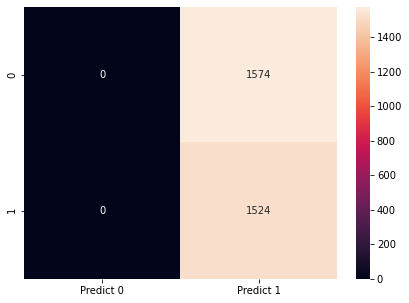

In [95]:
mat_train = confusion_matrix(y_test, RF_result.predict(X_test),labels=[0,1])

df_cm = pd.DataFrame(mat_train, index = [i for i in [0, 1]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='.4g')

In [96]:
print("\n\n\n Classification report for \n\n\n",classification_report(y_test,RF_result.predict(X_test),labels=[0,1]))




 Classification report for 


               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1574
           1       0.49      1.00      0.66      1524

    accuracy                           0.49      3098
   macro avg       0.25      0.50      0.33      3098
weighted avg       0.24      0.49      0.32      3098



C:\Users\ss1\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ss1\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ss1\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
def fit_n_print(X_train, X_test, y_train, y_test,gridsearch):  # take the model, train data and test data as input
    
    start = time.time()
    #print(gridsearch)# note the start time 
    
    grid_search = gridsearch.fit(X_train, y_train)
    #model.fit(X_train, y_train)
    # fit the model using the train data
    predicted_labels = gridsearch.predict(X_test)
    Accuracy = accuracy_score(y_test, predicted_labels, normalize=False)   # model predictions on the test data

    Precision = precision_score(y_test, predicted_labels,average='binary')  # calculate the r squared value on the test data
    
    Recall = recall_score(y_test, predicted_labels,average='binary')  # Root mean squared error
    
    F1_Score = f1_score(y_test,predicted_labels, average='binary')  # Root mean squared log error (since the numbers are huge)
    
    #scorer = {'r2' : metrics.make_scorer(metrics.r2_score),
              #'mse' : metrics.make_scorer(metrics.mean_squared_error),
              #'msle' : metrics.make_scorer(metrics.mean_squared_log_error),
              # }    # make scorers to be used in cross validation
    
    #cv = cross_validate(model, X_train, y_train, cv=10, scoring = scorer)   # perform cross validation accross 3 metrics
    
    best_params = grid_search.best_params_                                    # mean r squared value
    Train_Score = gridsearch.score(X_train, y_train) # mean RMSE value(take root of individual mse value and then mean)
    test_score = gridsearch.score(X_test, y_test) # mean RMSLE
    
    end = time.time()  #note the end time
    
    
    duration = end - start  # calculate the total duration
   

    
    
    return  Accuracy, Precision, Recall, F1_Score, best_params, Train_Score,  test_score,duration  # return all the metrics along with predictions

In [99]:
#from sklearn.metrics import classification_report,confusion_matrix
#lr = LinearRegression()        
#dt = DecisionTreeRegressor(random_state=1)   
#br = BaggingRegressor(random_state=1)
#rf = RandomForestRegressor(random_state=1, n_estimators=100)  # specifying n_estimators to avoid "future warnings"
#gb = GradientBoostingRegressor(random_state=1, n_estimators=100)
#bg = BaggingClassifier()
#n_estimators = [10, 100, 1000]
# define grid search
#grid = dict(n_estimators=n_estimators)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#grid_search = GridSearchCV(estimator=bg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
#grid_result = grid_search.fit(X_train, y_train)

result = {}   # Create an empty dictionary to later use to store metrics of each of the models
for model, name  in zip([Bg_model_grid_result,xgbresult,ab_result,Extreme_gb_result,cat_result,RF_result ], ['bagging','Xgb','adaboosting','ExtremeGradientBoosting','Cat model','Random Forest']):
    print(name)
    #print("\n\n\n Classification report for \n\n\n",classification_report(y_test, model.predict(X_test),labels=[0,1]))
   # print("\n\n\n Classification report for \n\n\n",classification_report(y_test, nb.predict(X_test),labels=[0,1]))
    
    result[name] = fit_n_print(X_train, X_test,y_train, y_test,model) 
    
# putting all 5 models in a for loop and appending the results of each of the models to the 'result' dictionary
 
    # store all the metrics in the result dict, with name as key
   
    

bagging
Xgb
Fitting 30 folds for each of 1 candidates, totalling 30 fits


C:\Users\ss1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
adaboosting
Fitting 30 folds for each of 1 candidates, totalling 30 fits
ExtremeGradientBoosting
Fitting 30 folds for each of 1 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Cat model
Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6766444	total: 6.47ms	remaining: 25.9ms
1:	learn: 0.6631435	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.6496545	total: 20.6ms	remaining: 13.7ms
3:	learn: 0.6372952	total: 26.7ms	remaining: 6.66ms
4:	learn: 0.6243284	total: 32.8ms	remaining: 0us
Random Forest
Fitting 30 folds for each of 

In [115]:
result_df = pd.DataFrame(result).T.iloc[:,:]

result_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'best_params', 'Train_Score', 'test_score','duration']
result_df

,Accuracy,Precision,Recall,F1-Score,best_params,Train_Score,test_score,duration
bagging,2605,0.835831,0.841864,0.838836,{'n_estimators': 1000},0.998626,0.841864,235.272
Xgb,2481,0.780111,0.82874,0.803691,"{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}",0.858203,0.82874,0.903998
adaboosting,2307,0.675948,0.923885,0.780704,"{'learning_rate': 0.05, 'n_estimators': 5}",0.91701,0.923885,0.533036
ExtremeGradientBoosting,2509,0.786283,0.84252,0.81343,"{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}",0.854905,0.84252,2.71996
Cat model,2386,0.717345,0.879265,0.790094,"{'learning_rate': 0.05, 'n_estimators': 5}",0.885133,0.879265,4.62672
Random Forest,1524,0.49193,1,0.659455,"{'bootstrap': False, 'ccp_alpha': 1.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 3}",1,1,127.552


In [116]:
pd.options.display.max_colwidth = 100000000
print(result_df.best_params)

bagging                                                                                                                                                                        {'n_estimators': 1000}
Xgb                        {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}
adaboosting                                                                                                                                                {'learning_rate': 0.05, 'n_estimators': 5}
ExtremeGradientBoosting    {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'seed': 1337, 'subsample': 0.8}
Cat model                                                                                                                                                  {'learning_rate': 0.05, 'n_estimators': 5}
Random For

In [122]:
xgbParams = {'n_estimators': 1000,'objective' : "binary:logistic",'eval_metric' : "logloss",'use_label_encoder' : False}
xgbresult =  XGBClassifier().set_params(**xgbParams)
extreme_gb_params = {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11,  'n_estimators': 5,   'subsample': 0.8,'use_label_encoder' : False}
Extreme_gb_result1 = lgb.LGBMClassifier()
#Extreme_gb_result1 = Extreme_gb_result.set_params(**extreme_gb_params)
cat_params = {'learning_rate': 0.05, 'n_estimators': 5}
cat_result1=CatBoostClassifier().set_params(**cat_params)
cat_result1=cat_result
rf_params ={'bootstrap': True, 'ccp_alpha': 1.0, 'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 3}
#odel = model.set_params(**parameters) 
#set_params(**params)[source]
RF_result1 =RandomForestClassifier()
#RF_result1 = RF_result.set_params(**rf_params)
ab_result1 =AdaBoostClassifier(algorithm = 'SAMME',learning_rate = 0.05, n_estimators= 5)


<h3> building stacking, own ensemble model </h3>

In [126]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


# set up the meta classifier (level 2 model)
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
#np.random.seed(RANDOM_SEED)
lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
sclf = StackingCVClassifier(classifiers=[ab_result1, Extreme_gb_result1, cat_result1,RF_result1, xgbresult1], 
                            use_probas=True,
                            use_features_in_secondary=True,
                            meta_classifier=lr,
                            cv=6)


# Set up K-Fold cross validation and predictions
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

#num_folds = 6
#folds = KFold(n_splits=num_folds, random_state=16)

test_result = np.zeros(len( y_test))
auc_score = 0



cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
#grid_search = GridSearchCV(sclf,n_jobs=-1, cv=cv, )
acc = cross_val_score(estimator=sclf, X=X_train, y=y_train, cv=cv)
#grid_result = grid_search.fit(X_train, y_train)
print(acc.std())
print(acc.mean())

Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6771814	total: 31.3ms	remaining: 125ms
1:	learn: 0.6640501	total: 34.2ms	remaining: 51.3ms
2:	learn: 0.6511735	total: 39.5ms	remaining: 26.3ms
3:	learn: 0.6389451	total: 42.7ms	remaining: 10.7ms
4:	learn: 0.6264800	total: 46.3ms	remaining: 0us
Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6768186	total: 30.7ms	remaining: 123ms
1:	learn: 0.6635513	total: 33.5ms	remaining: 50.3ms
2:	learn: 0.6486282	total: 36.5ms	remaining: 24.3ms
3:	learn: 0.6365508	total: 39.7ms	remaining: 9.93ms
4:	learn: 0.6244695	total: 43.1ms	remaining: 0us
Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6769692	total: 16.2ms	remaining: 64.8ms
1:	learn: 0.6639753	total: 19.9ms	remaining: 29.9ms
2:	learn: 0.6507515	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.6381593	total: 28.2ms	remaining: 7.06ms
4:	learn: 0.6254587	total: 31.9ms	remaining: 0us
Fitting 30 folds for each of 1 candidates, total

In [202]:

print("mean accuracy of staking model",acc.mean())

mean accuracy of staking model 0.8519664524928832


In [127]:
from sklearn.ensemble import VotingClassifier
estimators=[('ab_result',ab_result), ('Extreme_gb_result',Extreme_gb_result), ('cat_result', cat_result),('RF_result',RF_result),('xgbresult',xgbresult),('Bg_model_grid_result',Bg_model_grid_result)]
#create our voting classifier, inputting our models
ensembleVote = VotingClassifier(estimators, voting='soft')
#fit model to training data
ensembleVote.fit(X_train, y_train)
#test our model on the test data
print(ensembleVote.score(X_test, y_test))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Fitting 30 folds for each of 1 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6766444	total: 15.3ms	remaining: 61.1ms
1:	learn: 0.6631435	total: 18.4ms	remaining: 27.6ms
2:	learn: 0.6496545	total: 21.5ms	remaining: 14.4ms
3:	learn: 0.6372952	total: 24.9ms	remaining: 6.22ms
4:	learn: 0.6243284	total: 28.1ms	remaining: 0us
Fitting 30 folds for each of 448 candidates, totalling 13440 fits
0.842801807617818


In [203]:
print("voting classifier score",ensembleVote.score(X_test, y_test))

voting classifier score 0.842801807617818


<h3> Pickling model </h3>

In [131]:
Pkl_Filename = "ensembleAdaboost.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(ab_result, file)
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model
score = Pickled_LR_Model.score(X_test, y_test) 
print(score)

0.9238845144356955


In [176]:
ab_result1.fit(X_train,y_train)
cat_result1.fit(X_train,y_train)
Extreme_gb_result1.fit(X_train,y_train)

Fitting 30 folds for each of 1 candidates, totalling 30 fits
0:	learn: 0.6766444	total: 4.37ms	remaining: 17.5ms
1:	learn: 0.6631435	total: 9.22ms	remaining: 13.8ms
2:	learn: 0.6496545	total: 13.7ms	remaining: 9.14ms
3:	learn: 0.6372952	total: 17.9ms	remaining: 4.49ms
4:	learn: 0.6243284	total: 22.9ms	remaining: 0us


LGBMClassifier()

0.7310585786300049 0.7035913616179824 0.7475204020717232 1 1


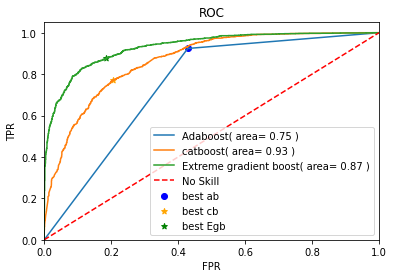

In [188]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from numpy import sqrt,argmax
ab_roc_auc =  roc_auc_score(y_test,ab_result1.predict_proba(X_test)[:,1])
cat_roc_auc =   roc_auc_score(y_test,cat_result1.predict_proba(X_test)[:,1])
fpr,tpr,threshold = roc_curve(y_test,ab_result1.predict_proba(X_test)[:,1])
fpr1,tpr1,threshold1 =roc_curve(y_test,cat_result1.predict_proba(X_test)[:,1])
ex_gradboost = roc_auc_score(y_test,Extreme_gb_result1.predict_proba(X_test)[:,1])
fpr2,tpr2,threshold2 =roc_curve(y_test,Extreme_gb_result1.predict_proba(X_test)[:,1])
gmeans = sqrt(tpr*1-fpr)
ix = argmax(gmeans)
ixNB =  argmax(sqrt(tpr1*1-fpr1))
ixexgb =argmax(sqrt(tpr2*1-fpr2))
print(threshold[ix],gmeans[ix],logit_roc_auc,ix,argmax(gmeans) )
plt.figure()
plt.plot(fpr,tpr,label = 'Adaboost( area= %0.2f )' % ab_roc_auc)

plt.plot(fpr1,tpr1,label = 'catboost( area= %0.2f )' % ex_gradboost)
plt.plot(fpr2,tpr2,label = 'Extreme gradient boost( area= %0.2f )' % cat_roc_auc)
plt.plot([0,1],[0,1],'r--',label = 'No Skill')
plt.scatter(fpr[ix],tpr[ix],marker ='o',color = 'blue',label ='best ab')
plt.scatter(fpr1[ixNB],tpr1[ixNB],marker ='*',color = 'orange',label ='best cb')
plt.scatter(fpr2[ixNB],tpr2[ixNB],marker ='*',color = 'green',label ='best Egb')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

Roc curve looks efficient for extreme gradient boosting

Best threshold = 0.501320, F-score =0.792


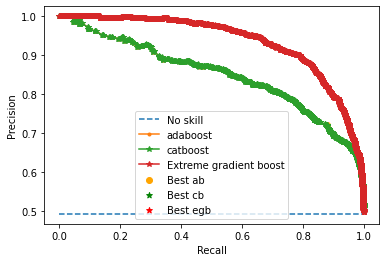

In [209]:
#precison recall
from sklearn.metrics import precision_recall_curve
yht =cat_result1.predict_proba(X_test)[:,1]

precision,recall,thresholds = precision_recall_curve(y_test,yht)
precision1,recall1,thresholds1 = precision_recall_curve(y_test,cat_result1.predict_proba(X_test)[:,1])
precision2,recall2,thresholds2 = precision_recall_curve(y_test,Extreme_gb_result1.predict_proba(X_test)[:,1])
fscore = (2*precision*recall)/(precision+recall)
fscoreNB = (2*precision1*recall1)/(precision1+recall1)
fscoreEcgb = (2*precision2*recall2)/(precision2+recall2)
ix = argmax(fscore)
ixnb =argmax(fscoreNB)
ixex =argmax(fscoreEcgb)
print('Best threshold = %f, F-score =%.3f'% (thresholds[ix],fscore[ix]))

no_skill = len(y_test[y_test==1])/len(y_test)
plt.plot([0,1],[no_skill,no_skill],linestyle = '--',label='No skill')
plt.plot(recall,precision,marker='.',label='adaboost')
plt.plot(recall1,precision1,marker='*',label='catboost')
plt.plot(recall2,precision2,marker='*',label='Extreme gradient boost')
plt.scatter(recall[ix],precision[ix],marker='o',color = 'orange',label='Best ab')
plt.scatter(recall1[ixnb],precision1[ixnb],marker='*',color = 'green',label='Best cb')
plt.scatter(recall1[ixnb],precision1[ixnb],marker='*',color = 'red',label='Best egb')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

catboost and adaboost has same precion recall recurve

<h3> Best model - Adaboost  with reacll of 0.92</h3>

- cost of error is high for false negative in churn rate identification

- falsly predicting the churner as non churner is high priority

- best metric for False Negative rate is Recall

- best Recall score out of techniques is 0.923885	

- best model with best recall score is Ada boost


<h3>why not random forest with recall score of 1 </h3>

- cost of error is high for false negative in churn rate identification

- Random forest has precision of just 0.49193	

- Training score is 1 , clearly it has overfitting problem

<h3> results <h3>

- Since we are focusing on recall, Adaboost is preferred with highest recall
    
     Classification report for adaboost 


               precision    recall  f1-score   support

           0       0.89      0.57      0.69      1574
           1       0.68      0.92      0.78      1524
    
- Recall score is high for class 1 ,falsely predicting the churner as non churner has high cost of error rate
    
    
- scaling doesn't impact the accuracy at higher scale
    
    
- undersampling seems to decrease the accuacy and oversamlpling seems to work fine
    
    
- Data is skewed and it has to be handled
    
    
-  Tenure and Monthlycharges has high values of Vif, having two features together creates collinearity problem as discussed below
    

In [215]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
  
print(vif_data)

             feature        VIF
0             gender   1.954856
1      SeniorCitizen   1.373354
2            Partner   2.819317
3         Dependents   1.957986
4             tenure  15.086501
5       PhoneService  15.198554
6      MultipleLines   2.761146
7    InternetService   4.379748
8     OnlineSecurity   2.257841
9       OnlineBackup   2.459222
10  DeviceProtection   2.631343
11       TechSupport   2.392227
12       StreamingTV   3.237959
13   StreamingMovies   3.265624
14          Contract   4.210618
15  PaperlessBilling   2.891712
16     PaymentMethod   3.109158
17    MonthlyCharges  22.374797
18      TotalCharges  14.366392
19             Churn   1.861969



<h6> Quality <h6>
    
    
    

- Data quality is good interms of processing

- If the data is up to date, we can get a clear picture in the churn rate
- clear description on feature can be helpful
<h6> Quantity <h6>
    
    

- 7000 records for 2 classes could be sufficient to derive pattern
<h6> Variety <h6>
    
    

- It has only structured data , so we dont require advanced tools for processing
- If the data covers competitor's charges for service, we can derive interesting insights on churn rates
<h6>veracity<h6>
    
    

- It has important features, It would be good if we can understand the provider name,cahrges for each service and charges for the same by competitor
<h6>velocity<h6>
    
    

- Analysing churn rate with 7k is not high veracity. Information isn't coming in high speed. so we dont require any advanced tools for processing

- buliduing ensembling model on top of 7k recors takes time with gridsearch, high time consumption is also due to the less Computing Power
